# Sigmoid Activation and Binary Crossentropy - A Less Than Perfect Match?
### Investigating concerns of numerical imprecision
This and similarly named notebooks contain calculations and illustrations of an article published on Towards Data Science in February 2019 to be found here:
https://towardsdatascience.com/sigmoid-activation-and-binary-crossentropy-a-less-than-perfect-match-b801e130e31. The explanatory prose corresonds largely to a draft version of the published article, plus a few post-publication comments.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import models, layers, optimizers, utils
# path to current project
import sys, os
sys.path.append("/mnt/hd_internal/hh/projects_DS/numeric_precision/")
from src.models.metrics_for_keras import bce_with_logits
# directory for figures
fig_dir = "../reports/figures/"

Using TensorFlow backend.


In [2]:
# graphics settings
# font sizes
plt.rcParams['font.size'] = 12
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['legend.fontsize'] = 10
# other text parameters
plt.rcParams['text.usetex'] = False # True activates latex output in fonts!
plt.rcParams['text.latex.preamble'] = "\\usepackage{subdepth}, \\usepackage{type1cm}"
# lines
plt.rcParams['lines.linewidth'] = 2.0
#plt.rcParams['lines.markersize'] = 8
# resolution of saved graphics
plt.rcParams['savefig.dpi'] = 300

In binary classification models, sigmoid activation in the last (output) layer and binary crossentropy (BCE) as the loss function are standard fare (see here for a brilliant explanation of BCE by Daniel Godoy). Yet, recently I stumbled across a statement that this specific combination of last layer-activation and loss may result in numerical imprecision (https://www.kaggle.com/iafoss/pretrained-resnet34-with-rgby-0-460-public-lb; search for 'However, combining the sigmoid' to get to the paragraph in question and further discussions thereof). I wanted to make sure I get the argument, down to the numbers, especially in the framework which I use so far,  Keras. So, let's start by taking a look at Keras' implementation of BCE:

In [3]:
# the code below is taken from Keras; the function name is changed to indicate as much:
def Keras_binary_crossentropy(target, output, from_logits=False):
    """Binary crossentropy between an output tensor and a target tensor.

    # Arguments
        target: A tensor with the same shape as `output`.
        output: A tensor.
        from_logits: Whether `output` is expected to be a logits tensor.
            By default, we consider that `output`
            encodes a probability distribution.

    # Returns
        A tensor.
    """
    # Note: tf.nn.sigmoid_cross_entropy_with_logits
    # expects logits, Keras expects probabilities.
    if not from_logits:
        # transform back to logits
        _epsilon = _to_tensor(epsilon(), output.dtype.base_dtype)
        output = tf.clip_by_value(output, _epsilon, 1 - _epsilon)
        output = tf.log(output / (1 - output))

    return tf.nn.sigmoid_cross_entropy_with_logits(labels=target,
                                                   logits=output)



So, it seems that values are clipped first, then converted to logits, and then fed into tensorflow function sigmoid_cross_entropy_with_logits. First of all, let's recapitulate logit(s). In mathematics, the logit function is the inverse of the sigmoid function, so in theory logit(sigmoid(x)) = x. Implementations of both are one-liners:

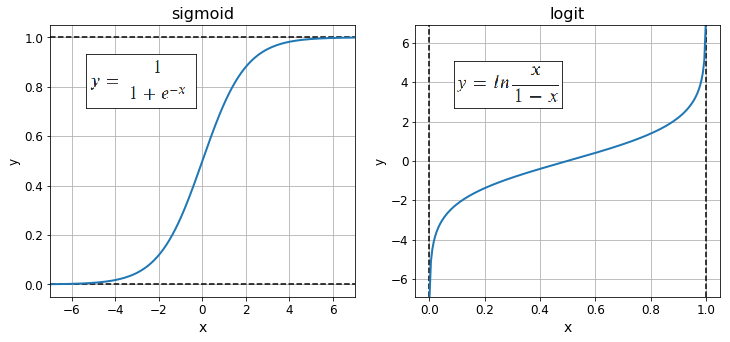

In [4]:
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

def logit(p):
    return np.log(p /(1.0 - p))

# plot
fh = plt.figure(figsize=(12,5))
# first, sigmoid
xmin, xmax = -7, 7
ymin, ymax = -0.05, 1.05
x_tmp = np.r_[xmin:xmax:200j]
axh1 = plt.subplot(1,2,1)
plt.plot(x_tmp, sigmoid(x_tmp))
axh1.hlines([0.0, 1.0], xmin, xmax, color='k', linestyles='--', linewidth=1.5)
plt.grid()
plt.axis((xmin, xmax, ymin, ymax))
plt.xlabel("x", fontsize=14)
plt.ylabel("y")
plt.title("sigmoid");
# add formula
saxh1 = plt.axes([0.12, 0.65, 0.22, 0.15], facecolor="w")
saxh1.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left=False,         # ticks along the top edge are off
    right=False,         # ticks along the top edge are off
    labelbottom=False, # labels along the bottom edge are off
    labelleft=False) # labels along the bottom edge are off
img = plt.imread(os.path.join(fig_dir, "formula_sigmoid.png"))
saxh1.imshow(img)

# next, logit
xmin, xmax = 1e-3, 1-1e-3
ymin, ymax = logit(xmin), logit(xmax)
x_tmp = np.r_[xmin:xmax:200j]
axh2 = plt.subplot(1,2,2)
plt.plot(x_tmp, logit(x_tmp))
axh2.vlines([0.0, 1.0], ymin, ymax, color='k', linestyles='--', linewidth=1.5)
plt.grid()
plt.axis((-.05, 1.05, ymin, ymax))
plt.xlabel("x", fontsize=14)
plt.ylabel("y")
plt.title("logit");
# add formula
saxh2 = plt.axes([0.555, 0.65, 0.20, 0.13], facecolor="w")
saxh2.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left=False,         # ticks along the top edge are off
    right=False,         # ticks along the top edge are off
    labelbottom=False, # labels along the bottom edge are off
    labelleft=False) # labels along the bottom edge are off
img = plt.imread(os.path.join(fig_dir, "formula_logit.png"))
saxh2.imshow(img)

plt.savefig(fig_dir + "logit_and_sigmoid.png", format="png")

$$y=\frac{1}{1+e^{-x}}$$


$$y=ln\frac{x}{1-x}$$


In Machine Learning, the term usually means the 'raw' outputs of the last layer of a classification network, that is, the output of the layer BEFORE it is passed to an activation/normalization function, e.g. the sigmoid. Logits may take on any value. This is what tf.nn.sigmoid_cross_entropy_with_logits, the core of Keras' binary_crossentropy function, expects. From the code above we learn that in Keras, by contrast, the expectation is that the values in variable 'output' represent probabilities and are therefore bounded by [0 1] - that's why 'from_logits' is by default set to False. So, the values need to be converted back to logits before being fed into tf.nn.sigmoid_cross_entropy_with_logits. In other words, we are first running the raw output values through one function (sigmoid), only to convert them back using the inverse function (logit). This appears circuitous. The real problem, though, is the numerical instability that this to and fro may cause, resulting in an overflow in the extreme case. Look at the output of y = logit(sigmoid(x)) when x is of type float32, the default:

/home/hh/anaconda3/envs/airbus_anomaly_detection/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


1% error margin reached at x = 14.639639854431152
Division by zero reached at = 16.591590881347656


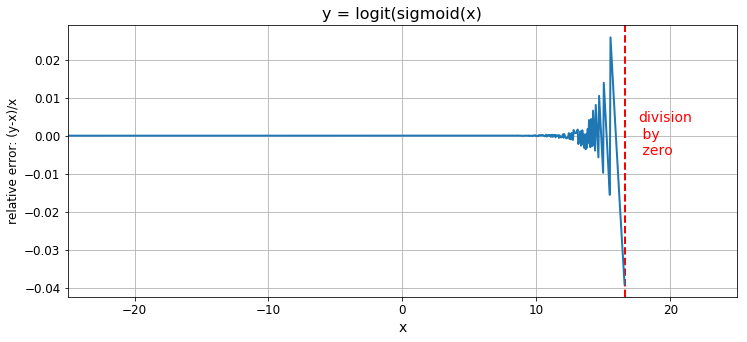

In [5]:
# define a finely grained range of logit values: 
# note that we're using the default 32 bit floating point precision in Keras/tensorflow, 
# otherwise the exercise would be pointless
x = np.r_[-25:25:1000j].astype(np.float32)
y = logit(sigmoid(x))
# find x values at which error exceeds 1% and zero division occurs, respectively
x_zero_div = x[np.argmax(np.abs((y-x)/x) == np.inf) - 1]
x_p = x[np.argmax(np.abs((y-x)/x) > 0.01) - 1]

# plot
fh = plt.figure(figsize=(12,5))
axh = plt.subplot(111)
plt.plot(x, (y-x)/x)
plt.grid()
plt.xlabel("x", fontsize=14)
plt.ylabel("relative error: (y-x)/x")
plt.title("y = logit(sigmoid(x)")
axh.set_xlim((x[0], x[-1]))
xmin, xmax, ymin, ymax = plt.axis()
axh.vlines(x_zero_div, ymin, ymax, color='r', linestyle='--', linewidth=2)
plt.text(x_zero_div+1, -0.005, "division\n by\n zero", fontsize=14, color='r')
plt.axis((xmin, xmax, ymin, ymax))
plt.savefig(fig_dir + "logit_of_sigmoid.png", format="png")
# put out information
print("1% error margin reached at x = {}".format(x_p))
print("Division by zero reached at = {}".format(x_zero_div))

Starting at about x=14.6 errors hit the 1% range, and above about x=16.6 game's over due to division by zero. Division by zero occurs when the denominator in the sigmoid (1.0 + exp(-x)) evaluates to 1.0 and the denominator in the logit then evaluates to zero. [We could have estimated the critical cutoff of x via np.log(np.finfo(np.float32).eps), but I found the numerical zigzagging before it illuminating and worth showing]. Anyways, this is why the values of input variable 'output' in the Keras function need to be clipped. The result is of course a flattening of the loss function at the borders. To illustrate this, I copied the neat trick of setting up a minimalistic network with manually set weights (https://stackoverflow.com/questions/52125924/why-does-sigmoid-crossentropy-of-keras-tensorflow-have-low-precision). Thus, we are able to compare the values of BCE as computed from sigmoid activation in Keras with the values computed from logits in tensorflow:

In [6]:
model_p = models.Sequential()
model_p.add(layers.Dense(1, input_dim=1, activation="sigmoid"))
# set layer weights manually
model_p.layers[0].set_weights([np.array([1.0]).reshape((1,1)), np.array([0.0])])
model_p.compile(loss="binary_crossentropy", optimizer="RMSprop")

Here's the model without sigmoid activation, using a custom-made loss function which plugs the values directly into tf.nn.sigmoid_cross_entropy_with_logits:

In [7]:
model_logit = models.Sequential()
model_logit.add(layers.Dense(1, input_dim=1, activation=None))
# set layer weights manually
model_logit.layers[0].set_weights([np.array([1.0]).reshape((1,1)), np.array([0.0])])
model_logit.compile(loss=bce_with_logits, optimizer="RMSprop")

So, if we evaluate the models on a sweeping range of scalar inputs x, setting the label (y) to 1, we can compare the model-generated BCEs with each other and also to the values produced by a naive implementation of BCE computed with a high-precision float:

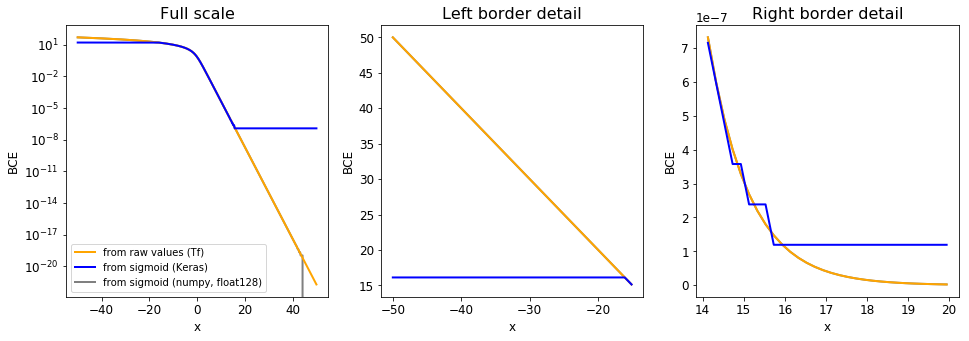

In [8]:
# range of logit values
x = np.r_[-50:50:500j].astype(np.float32)
# the same, but at best precision for comparison
x_128 = np.r_[-50:50:500j].astype(np.float128)
loss_p = np.empty(x.shape)
loss_logit = np.empty(x.shape)
# the expected values of BCE, computed with high precision
loss_expected = -np.log(sigmoid(x_128))
# equivalent, as described in the help to sigmoid_cross_entropy_with_logits:
#loss_expected = np.maximum(x_128, np.float128(0.0)) - x_128 + np.log(np.float128(1.0) + np.exp(-np.abs(x_128)))

col_p = "b"
col_logit = "orange"
col_expected = "gray"

for ix, xi in enumerate(x):
    loss_p[ix] = model_p.evaluate(x=np.array([xi]), y=np.array([1]), verbose=0)
    loss_logit[ix] = model_logit.evaluate(x=np.array([xi]), y=np.array([1]), verbose=0)

fh, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(16,5))
ph1 = ax1.semilogy(x_128, loss_expected, color=col_expected)
ph2 = ax1.semilogy(x, loss_logit, color=col_logit)
ph3 = ax1.semilogy(x, loss_p, color=col_p)
ax1.set(xlabel="x", ylabel="BCE", title='Full scale')
# define artists for the legend (wtf!)
ph1 = matplotlib.lines.Line2D([], [], color=col_expected)
ph2 = matplotlib.lines.Line2D([], [], color=col_logit)
ph3 = matplotlib.lines.Line2D([], [], color=col_p)
ax1.legend([ph2, ph3, ph1],["from raw values (Tf)", "from sigmoid (Keras)", "from sigmoid (numpy, float128)"])

# plot of fine detail on the left border (note linear scale)
ix = x < -15
ax2.plot(x_128[ix], loss_expected[ix], color=col_expected)
ax2.plot(x[ix], loss_logit[ix], color=col_logit)
ax2.plot(x[ix], loss_p[ix], color=col_p)
ax2.set(xlabel="x", ylabel="BCE", title='Left border detail')

# plot of fine detail on the right border
ix = (x > 14) & (x < 20)
ax3.plot(x_128[ix], loss_expected[ix], color=col_expected)
ax3.plot(x[ix], loss_logit[ix], color=col_logit)
ax3.plot(x[ix], loss_p[ix], color=col_p)
ax3.set(xlabel="x", ylabel="BCE", title='Right border detail');
plt.savefig(fig_dir + "BCE.png", format="png")

Interesting! The curve computed from logits using TF's sigmoid_cross_entropy_with_logits is smooth across the range of x values tested, whereas the curve computed from sigmoid activation flattens in both directions. Before hitting the clipping-induced limit, the sigmoid-derived curve shows a step-like appearance towards large x values. Good to know! And even with a float128 we won't get very far if we derive the BCE values from sigmoid-transformed input (gray curve in leftmost plot).

As the loss function is central to learning via backpropagation, this means that a model employing sigmoid + BCE cannot discriminate among samples whose predicted class is either in extreme accordance (x > 16.6) or extreme discordance (x < -16) with their labels. So, in theory it is true that we are limited by sigmoid + BCE. However, does it matter in practice? After all, we are talking about extreme edge cases. Well, only experiments can tell.